In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skd
import sklearn.preprocessing as skp
import sklearn.neighbors as skn
import sklearn.metrics as skmt
import scipy.sparse as spr
rng = np.random.default_rng(100)
scaler = skp.StandardScaler()

In [2]:
alpha = 0.5
beta1 = 0.9
beta2 = 0.999
epsilon = 10 ** (-8)

In [3]:
gamma = 50000
mu = 100
k = 5
phi = 0.01
N = 100
tol1 = 0.1
tol2 = 0.5

In [4]:
def add_noise(X, label, p):
    n, d = X.shape
    r = int(p * n)
    noise = rng.uniform(0, 1, (r, d))
    noise = X.min(0) + (X.max(0) - X.min(0)) * noise
    noise_index = np.zeros(r)
    noise_index.fill(-1)
    
    new_X = np.concatenate((X, noise))
    new_label = np.concatenate((label, noise_index))
    return new_X, new_label

In [5]:
def calculate_W(X):
    n = X.shape[0]
    W = skn.kneighbors_graph(X, n_neighbors = k, mode = "distance")
    W = W.toarray()

    for i in range(n):
        for j in range(i + 1, n):
            if W[i, j] > 0:
                W[i, j] = np.exp((-phi) * W[i, j])
                W[j, i] = W[i, j]
    
    return W

In [6]:
def find_median(X, U, B):
    l = B.shape[0]
    cost = np.zeros(l)
    for i in range(l):
        for j in B[i]:
            cost[i] = cost[i] + ((U[j] - X[j]) * (U[j] - X[j])).sum()
    lt = np.where(cost >= np.median(cost))[0][0]
    return lt

In [7]:
def calculate_grad(X, U, BI):
    n, d = U.shape
    grad = np.zeros([n, d])
    for j in range(n):
        if j in BI:
            grad[j] = grad[j] + (U[j] - X[j]) / b
        for i in np.where(W[j] > 0)[0]:
            if ((U[j] - U[i]) * (U[j] - U[i])).sum() < mu:
                grad[j] = grad[j] + (gamma * W[i, j]) * (U[j] - U[i])
    return grad

Noise : 0.0
Iterations : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Number of clusters : 2.0 +/- 0.0
ARI : 1.0 +/- 0.0
NNMI : 1.0 +/- 0.0

Noise : 0.05
Iterations : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Number of clusters : 2.0 +/- 0.0
ARI : 1.0 +/- 0.0
NNMI : 1.0 +/- 0.0

Noise : 0.1
Iterations : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Number of clusters : 2.1333333333333333 +/- 0.33993463423951903
ARI : 0.9932291223698614 +/- 0.02328923700992348
NNMI : 0.991689170957223 +/- 0.02696855321910278

Noise : 0.15000000000000002
Iterations : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Number of clusters : 1.8 +/- 0.5416025603090641
ARI : 0.7260269891064441 +/- 0.4384136444601985
NNMI : 0.7238830535931603 +/- 0.43735554102152124

Noise : 0.2
Iterations : 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Number of clusters : 1.9333333333333333 +/- 0.8537498983243799
ARI : 0.6192049595333597 +/- 0.44749199523473543
NNMI : 0.6251327343476533 +/- 0.4493159700250917



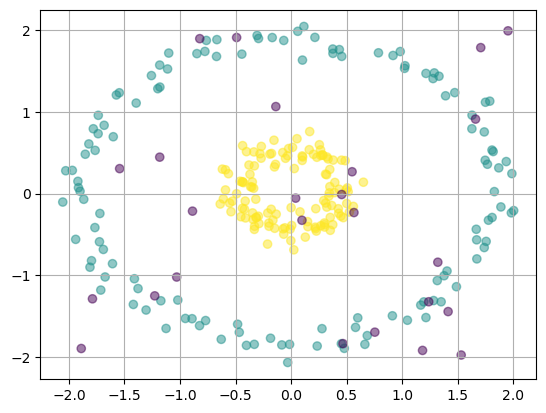

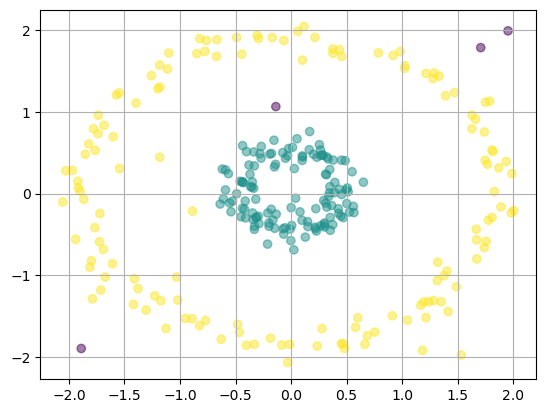

In [8]:
# data, label = skd.make_blobs(n_samples = 500, random_state = 100) # tol1 = 0.01
data, label = skd.make_circles(n_samples = 250, factor = 0.25, noise = 0.05, random_state = 0) # tol1 = 0.1

t = np.arange(250)

for m in range(5):
    
    print("Noise :", 0.05 * m)
    print("Iterations :", end = " ")

    k_star = []
    ari = []
    nnmi = []

    for h in range(15):

        X, label = add_noise(data, label, 0.05 * m)
        X = scaler.fit_transform(X)
    
        n, d = X.shape
        l = n // 25
        b = n // l
        W = calculate_W(X)
    
        U = np.copy(X)
        M = np.zeros([n, d])
        V = np.zeros([n, d])

        for i in range(1, N + 1):
            temp = rng.permutation(np.arange(l * b))
            B = np.array(np.split(temp, l))
            lt = find_median(X, U, B)
            G = calculate_grad(X, U, B[lt])
            M = beta1 * M + (1 - beta1) * G
            V = beta2 * V + (1 - beta2) * (G * G).sum()
            M_hat = M / (1 - beta1 ** i)
            V_hat = V / (1 - beta2 ** i)
            U = U - (alpha * M_hat) / np.sqrt(V_hat + epsilon)

        W_U = skmt.pairwise_distances(U) ** 2
        eta = tol1 * (W_U.sum() / (n ** 2))

        adj = (W_U <= eta).astype(int)
        temp = spr.csr_matrix(adj)
        r, Z = spr.csgraph.connected_components(temp, directed = False)

        temp_Z = np.unique(Z)
        r = temp_Z.shape[0]
        eta = tol2 * (n / r)

        for i in range(r):
            temp = np.where(Z == temp_Z[i])[0]
            if temp.shape[0] <= eta:
                Z[temp] = -1

        if (m == 2) and (h == 1):

            plt.figure()
            plt.scatter(X[:, 0], X[:, 1], c = label, alpha = 0.5)
            plt.grid()
            plt.savefig("comet_original.png")
    
            plt.figure()
            plt.scatter(X[:, 0], X[:, 1], c = Z, alpha = 0.5)
            plt.grid()
            plt.savefig("comet.png")

        label = label[t]
        Z = Z[t]

        print((h + 1), end = " ")
        k_star.append(np.unique(Z).shape[0])
        ari.append(skmt.adjusted_rand_score(label, Z))
        nnmi.append(skmt.adjusted_mutual_info_score(label, Z))

    print()
    print("Number of clusters :", np.array(k_star).mean(), "+/-", np.array(k_star).std())
    print("ARI :", np.array(ari).mean(), "+/-", np.array(ari).std())
    print("AMI :", np.array(nnmi).mean(), "+/-", np.array(nnmi).std())
    print()